In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
itemcate = pd.read_csv('data/item_categories.csv')
item = pd.read_csv('data/items.csv')
train = pd.read_csv('data/sales_train.csv')
sample = pd.read_csv('data/sample_submission.csv')
shop = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')

In [172]:
item.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [6]:
itemcate.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [7]:
shop.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [8]:
sample.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [9]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


Predict `item_cnt_month` ! each shop & item

In [11]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [12]:
train.tail(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# 0. Preprocessing

In [17]:
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [46]:
train['date'] = pd.to_datetime(train['date'], dayfirst=True) # day.month.year -> so we need 'dayfirst=True'

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [7]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [25]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


There is minus in `item_price`, `item_cnt_day` . maybe we need to delete !

In [47]:
train = train.loc[train['item_cnt_day'] > 0]
train = train.loc[train['item_price'] > 0]

## 1. EDA

In [14]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,2013-01-02,0,59,22154,999.00,1.0,1
1,2013-01-03,0,25,2552,899.00,1.0,1
3,2013-01-06,0,25,2554,1709.05,1.0,1


In [21]:
train.shape

(2928492, 7)

In [22]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
count,2.928492e+06,2.928492e+06,2.928492e+06,2.928492e+06,2.928492e+06,2.928492e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894668e+02,1.248337e+00,6.248407e+00
std,9.422951e+00,1.622543e+01,6.324396e+03,1.727499e+03,2.619586e+00,3.535924e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00,1.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00,3.000000e+00
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00,6.000000e+00
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00,9.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,1.200000e+01


### Train time

In [29]:
timeMin=train['date'].min()
timeMax=train['date'].max()
print(f'Time min : {timeMin}')
print(f'Time max : {timeMax}')

Time min : 2013-01-01 00:00:00
Time max : 2015-10-31 00:00:00


### train vs test : shop, item

In [39]:
shopUnique = train['shop_id'].unique()
itemUnique = train['item_id'].unique()

testShopUnique = test['shop_id'].unique()
testItemUnique = test['item_id'].unique()

print('shop :',len(testShopUnique) - pd.Series(testShopUnique).isin(shopUnique).sum())
print('item :',len(testItemUnique) - pd.Series(testItemUnique).isin(itemUnique).sum())

shop : 0
item : 363


There are 363 items that are only in test set!!

### grouby month 'item_cnt_day'

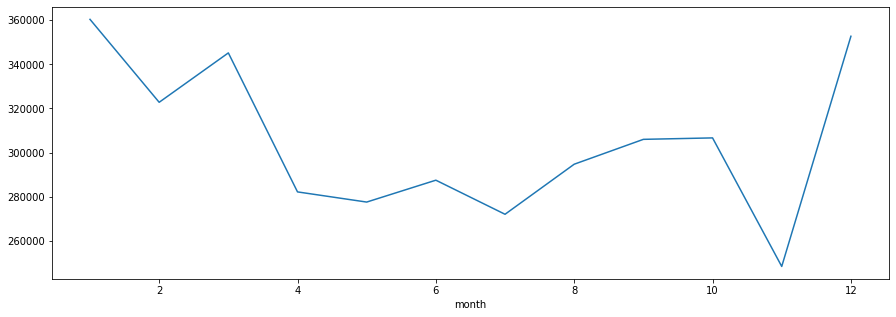

In [52]:
train['month'] = train['date'].dt.month
train.groupby('month')['item_cnt_day'].sum().plot(figsize=(15,5))

### grouby year 'item_cnt_day'

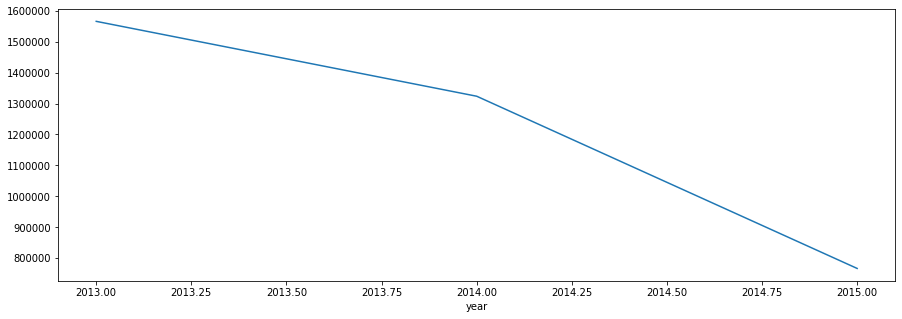

In [53]:
train['year'] = train['date'].dt.year
train.groupby('year')['item_cnt_day'].sum().plot(figsize=(15,5))

### groupby shop 'item_cnt_day'

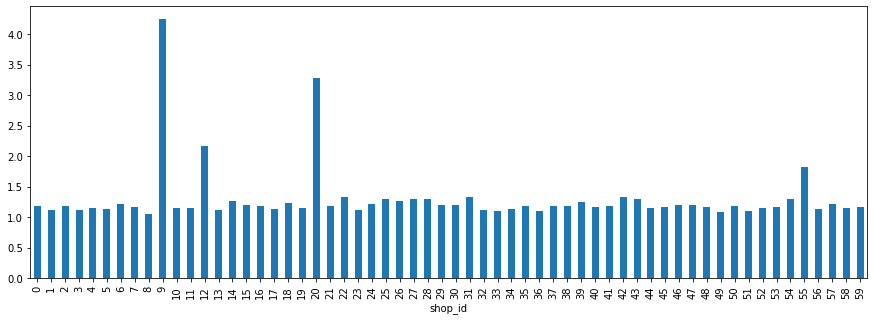

In [19]:
train.groupby('shop_id')['item_cnt_day'].mean().plot(kind='bar', figsize=(15,5))

### outlier

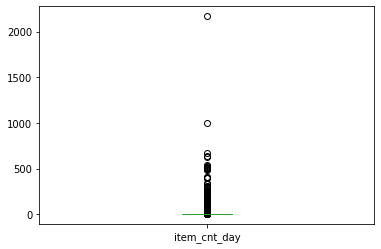

In [42]:
train['item_cnt_day'].plot(kind='box')
plt.show()

In [48]:
train[train['item_cnt_day'] > 500]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1573253,2014-04-22,15,27,8057,1200.000000,502.0
1708207,2014-06-28,17,25,20949,5.000000,501.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2067669,2014-10-09,21,55,19437,899.000000,508.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2608040,2015-04-14,27,12,3731,1904.548077,624.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0


In [55]:
train['item_cnt_day'].quantile(0.99)

5.0

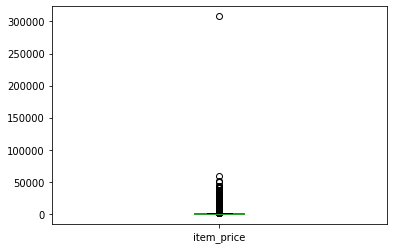

In [58]:
train['item_price'].plot(kind='box')
plt.show()

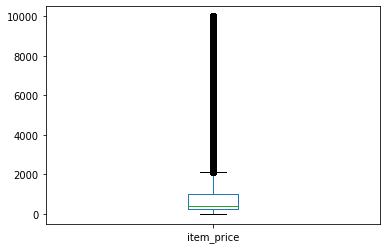

In [62]:
train.loc[train['item_price'] < 10000, 'item_price'].plot(kind='box')
plt.show()

In [60]:
train['item_price'].quantile(0.99)

5999.0

Delete some points

In [58]:
train1 = train[train['item_cnt_day'] < 1000]
train1 = train1[train1['item_price'] < 10000]

In [59]:
train1.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year
2935844,2015-10-10,33,25,7409,299.0,1.0,10,2015
2935845,2015-10-09,33,25,7460,299.0,1.0,10,2015
2935846,2015-10-14,33,25,7459,349.0,1.0,10,2015
2935847,2015-10-22,33,25,7440,299.0,1.0,10,2015
2935848,2015-10-03,33,25,7460,299.0,1.0,10,2015


In [60]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [61]:
traintmp = pd.merge(train1, item[['item_id','item_category_id']], how='left')
print(traintmp.shape)
traintmp.head()

(2908852, 9)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,item_category_id
0,2013-01-02,0,59,22154,999.00,1.0,1,2013,37
1,2013-01-03,0,25,2552,899.00,1.0,1,2013,58
2,2013-01-06,0,25,2554,1709.05,1.0,1,2013,58
3,2013-01-15,0,25,2555,1099.00,1.0,1,2013,56
4,2013-01-10,0,25,2564,349.00,1.0,1,2013,59


In [62]:
trainMonthly = traintmp.groupby(['date_block_num','shop_id','item_id','item_category_id'])\
                .agg({'item_price':['mean'], 'item_cnt_day':['mean','sum'], 'month':['mean'], 'year':['mean']})
trainMonthly.head()

item_price item_cnt_day       \
                                                      mean         mean  sum   
date_block_num shop_id item_id item_category_id                                
0              0       32      40                    221.0          1.5  6.0   
                       33      37                    347.0          1.0  3.0   
                       35      40                    247.0          1.0  1.0   
                       43      40                    221.0          1.0  1.0   
                       51      57                    128.5          1.0  2.0   

                                                month  year  
                                                 mean  mean  
date_block_num shop_id item_id item_category_id              
0              0       32      40                   1  2013  
                       33      37                   1  2013  
                       35      40                   1  2013  
                       43      40                   1  2013  
                       51      57                   1  2013

In [63]:
trainMonthly = trainMonthly.reset_index()
trainMonthly.columns = ['date_block_num','shop_id','item_id','item_category_id','item_price_mean','item_cnt_day_mean','item_cnt_day_sum','month','year']

In [77]:
trainMonthly.tail()

,date_block_num,shop_id,item_id,item_category_id,item_price_mean,item_cnt_day_mean,item_cnt_day_sum,month,year
1599511,33,59,22087,83,119.0,2.0,6.0,10,2015
1599512,33,59,22088,83,119.0,1.0,2.0,10,2015
1599513,33,59,22091,83,179.0,1.0,1.0,10,2015
1599514,33,59,22100,42,629.0,1.0,1.0,10,2015
1599515,33,59,22102,42,1250.0,1.0,1.0,10,2015


In [64]:
trainMonthlyTmp = trainMonthly.copy()

We have to predict `date_block_num` = 34

## 2. FE

creating target

In [65]:
trainMonthly['target'] = trainMonthly.groupby(['shop_id', 'item_id'])['item_cnt_day_sum'].shift(-1)

Rolling window based features

In [66]:
trainMonthly['item_cnt_min'] =  trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                    ['item_cnt_day_sum'].rolling(window=3, min_periods=1).min().values
trainMonthly['item_cnt_max'] =  trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                    ['item_cnt_day_sum'].rolling(window=3, min_periods=1).max().values
trainMonthly['item_cnt_mean'] = trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                    ['item_cnt_day_sum'].rolling(window=3, min_periods=1).mean().values
trainMonthly['item_cnt_std'] =  trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                    ['item_cnt_day_sum'].rolling(window=3, min_periods=1).std().values

Lag based feature

In [67]:
trainMonthly['item_cnt_shifted1'] = trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                        ['item_cnt_day_sum'].shift(1).values
trainMonthly['item_cnt_shifted2'] = trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                        ['item_cnt_day_sum'].shift(2).values
trainMonthly['item_cnt_shifted3'] = trainMonthly.groupby(['shop_id', 'item_category_id', 'item_id'])\
                                        ['item_cnt_day_sum'].shift(3).values

trainMonthly

In [68]:
trainMonthly = trainMonthly.fillna(0)
trainMonthly.head(3)

,date_block_num,shop_id,item_id,item_category_id,item_price_mean,item_cnt_day_mean,item_cnt_day_sum,month,year,target,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,0,32,40,221.0,1.5,6.0,1,2013,10.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0,0,33,37,347.0,1.0,3.0,1,2013,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0,0,35,40,247.0,1.0,1.0,1,2013,14.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Train/Validation split
- train : `date_block_num` 3~28
- val : `date_block_num` 29~32
- test : `date_block_num` 33 -> predict `date_block_num` 34's item_cnt

In [111]:
trainSet = trainMonthly.loc[trainMonthly['date_block_num'] >= 3,:]
trainSet = trainSet.loc[trainSet['date_block_num'] <= 28,:]

In [172]:
valSet = trainMonthly.loc[trainMonthly['date_block_num'] >= 29,:]
valSet = valSet.loc[valSet['date_block_num'] <=32,:]

In [113]:
testSet = trainMonthly.loc[trainMonthly['date_block_num']==33,:]

In [162]:
print(trainSet.shape)
print(valSet.shape)
print(testSet.shape)

(1254230, 21)
(127890, 17)
(31280, 17)


Catboost encoding

In [115]:
from category_encoders.cat_boost import CatBoostEncoder

cb = CatBoostEncoder(cols=['shop_id','item_id','year','month'])
cb.fit(trainSet[['shop_id','item_id','year','month']], trainSet['target'])
tmp = cb.transform(trainSet[['shop_id','item_id','year','month']])

In [116]:
tmp.head(3)

,shop_id,item_id,year,month
186116,1.522606,1.334530,1.803613,1.576109
186117,1.522606,2.213996,1.803613,1.576109
186118,1.522606,3.115304,1.803613,1.576109


In [117]:
tmp.columns = ['shop_id_en','item_id_en','year_en','month_en']

trainSet = pd.concat([trainSet, tmp], axis=1)

In [171]:
encodingTmp = X_train[['shop_id','item_id','shop_id_en', 'item_id_en', 'year_en', 'month_en']]
encodingTmp = encodingTmp.drop_duplicates(['shop_id','item_id'], keep='last')

In [173]:
en_col = tmp.columns.tolist()
on_col = ['shop_id','item_id']
valSet = pd.merge(valSet, encodingTmp, on=on_col, how='left')

In [177]:
valSet.fillna(valSet.mean(), inplace=True)

In [178]:
X_train = trainSet.drop(['target','date_block_num'],axis=1)
y_train = trainSet['target']
X_val = valSet.drop(['target','date_block_num'],axis=1)
y_val = valSet['target']

In [179]:
print(test.shape)

(214200, 3)


In [180]:
X_test = pd.merge(test.loc[:,['shop_id','item_id']], testSet, on=['shop_id','item_id'], how='left')
X_test = X_test.drop(['target','date_block_num'], axis=1)

In [181]:
X_test.shape

(214200, 15)

In [182]:
X_test = pd.merge(X_test, encodingTmp,
                     on=['shop_id','item_id'], how='left')
X_test.fillna(X_test.mean(), inplace=True)

In [183]:
X_test.shape

(214200, 19)

In [3]:
# import pickle

# X_train = pd.read_pickle('X_train.pkl')
# X_val = pd.read_pickle('X_val.pkl')
# X_test = pd.read_pickle('X_test.pkl')
# y_train = pd.read_pickle('y_val.pkl')
# y_val = pd.read_pickle('y_val.pkl')

In [184]:
X_train.drop('item_category_id', inplace=True, axis=1)
X_val.drop('item_category_id', inplace=True, axis=1)
X_test.drop('item_category_id', inplace=True, axis=1)

## 3. modeling

In [186]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1254230, 18)
(127890, 18)
(214200, 18)


CatBoost

In [10]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor

In [189]:
cat_features = [0, 1, 5, 6]

catboost_model = CatBoostRegressor(
    iterations=1000,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    verbose=50,
    depth=4,
    task_type='GPU',
    early_stopping_rounds=500
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
)

Learning rate set to 0.233825
0:	learn: 7.0821142	test: 9.4547823	best: 9.4547823 (0)	total: 56.5ms	remaining: 56.5s
50:	learn: 3.7590045	test: 8.7657614	best: 8.7657614 (50)	total: 2.88s	remaining: 53.6s
100:	learn: 3.4862802	test: 8.7507988	best: 8.7178535 (69)	total: 5.5s	remaining: 48.9s
150:	learn: 3.3409130	test: 8.7315902	best: 8.7178535 (69)	total: 8.35s	remaining: 47s
200:	learn: 3.2442727	test: 8.7354732	best: 8.7178535 (69)	total: 11.1s	remaining: 44.3s
250:	learn: 3.1432661	test: 8.7426177	best: 8.7178535 (69)	total: 13.9s	remaining: 41.4s
300:	learn: 3.0902920	test: 8.7458360	best: 8.7178535 (69)	total: 16.6s	remaining: 38.6s
350:	learn: 3.0306871	test: 8.7439078	best: 8.7178535 (69)	total: 19.3s	remaining: 35.7s
400:	learn: 2.9832828	test: 8.7491706	best: 8.7178535 (69)	total: 22s	remaining: 32.9s
450:	learn: 2.9380688	test: 8.7404696	best: 8.7178535 (69)	total: 24.6s	remaining: 30s
500:	learn: 2.8967372	test: 8.7462902	best: 8.7178535 (69)	total: 27.3s	remaining: 27.2s
5

In [190]:
X_test['year'] = X_test['year'].map(int)
X_test['month'] = X_test['month'].map(int)

In [191]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_val)
catboost_test_pred = catboost_model.predict(X_test)

In [192]:
from sklearn.metrics import mean_squared_error

print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, catboost_val_pred)))

Train rmse: 3.812062934123286
Validation rmse: 8.71785359656244


In [193]:
pd.DataFrame(catboost_model.feature_importances_, X_train.columns)

,0
shop_id,3.769626
item_id,9.615486
item_price_mean,0.221854
item_cnt_day_mean,2.152355
item_cnt_day_sum,73.963161
month,1.904131
year,0.193884
item_cnt_min,0.000000
item_cnt_max,0.000000
item_cnt_mean,0.000000


Randomforest

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [194]:
rf_train = X_train.drop('item_cnt_day_sum', axis=1)
rf_val = X_val.drop('item_cnt_day_sum', axis=1)
rf_test = X_test.drop('item_cnt_day_sum', axis=1)

In [195]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=500, n_jobs=-1, random_state=0)

In [196]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [197]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, rf_val_pred)))

Train rmse: 3.2189292185581735
Validation rmse: 8.718421728704827


In [203]:
pd.DataFrame(rf_model.feature_importances_, rf_train.columns).sort_values(by=0,ascending=False)

,0
item_id_en,0.344178
item_cnt_day_mean,0.253582
item_cnt_shifted1,0.235516
item_cnt_shifted2,0.033259
shop_id_en,0.030432
month_en,0.028241
item_price_mean,0.013570
item_id,0.011982
item_cnt_shifted3,0.011258
month,0.009464


Linear models

In [45]:
from sklearn.linear_model import LinearRegression

In [205]:
lr_features = ['item_id_en','item_cnt_day_mean','item_cnt_shifted1','item_cnt_shifted2','shop_id_en','month_en','item_price_mean']
lr_train = X_train[lr_features]
lr_val = X_val[lr_features]
lr_test = X_test[lr_features]

In [207]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, y_train)

LinearRegression(n_jobs=-1)

In [208]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [209]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, lr_val_pred)))

Train rmse: 5.227883514717971
Validation rmse: 9.02482345584653


## 4. Stacking

In [210]:
meta_model = LinearRegression(n_jobs=-1)

In [222]:
first_level = pd.DataFrame(catboost_val_pred)
first_level.columns = ['catboost']
first_level['rf'] = rf_val_pred
first_level['lr'] = lr_val_pred

In [223]:
first_level_test = pd.DataFrame(catboost_test_pred)
first_level_test.columns = ['catboost']
first_level_test['rf'] = rf_test_pred
first_level_test['lr'] = lr_test_pred

In [224]:
meta_model.fit(first_level, y_val)

LinearRegression(n_jobs=-1)

In [225]:
ensemble_val_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [226]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_val_pred, y_val)))

Train rmse: 8.612065674530646


In [227]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,2.148668
1,1,0.720777
2,2,1.240623
3,3,0.720777
4,4,0.720777
5,5,1.159595
6,6,0.259611
7,7,1.342430
8,8,3.442990
9,9,0.720777
